Os seguintes scripts são uma versão Python do curso de Machine Learning do professor Andrew Ng da universidade de Stanford leccionado na plataforma Coursera.

**Nota: Todos os dados e estrutura do exercício pertencem à Universidade de Stanford**

**Ressalva:** Os scripts não estão implementados de forma modular para todas as funções serem consultadas no mesmo Jupyter Notebook - ao contrário da implementação Octave.

# Exercício 1 - Carregar e Visualizar os Dados

In [1]:
# Importar o numpy para lidar com matrizes e vectores
import numpy as np
# Importar o pandas para ler os ficheiros
import pandas as pd
# Importar o matplotlib para fazer gráficos
import matplotlib.pyplot as plt

# Importar o módulo matemático
import math 

# Importar as funções de optimização e de rotação de imagem do scipy
from scipy import optimize, io
from scipy.ndimage import rotate

# Importar a função de módulo da library de álgebra linear
from numpy.linalg import norm

%matplotlib inline

In [2]:
# Usar o scipy Io para carregar o objecto matricial
ex4_file = io.loadmat('ex4data1.mat')
X = np.array(ex4_file['X'])
y = np.array(ex4_file['y'])

print('# exemplos de treino: {}'.format(len(X)))
m = len(X)

# exemplos de treino: 5000


In [3]:
# Definir os parâmetros iniciais da rede neuronal.

nos_camada_entrada = 400
nos_camada_oculta = 25
num_targets = 10

Semelhante ao exercício 3, estes dados refletem uma porção do MNIST, consistindo em representações vectoriais de dígitos escritos à mão.

Os dados contém um vector de 400 dimensões com intensidades de cor cinza. Ao re-dimensionarmos o vector somos capazes de visualizar as imagens. 

**Vamos fazer um gráficos com 100 imagens abaixo.**

In [4]:
# Selecionar 100 índices aleatórios para colocar no gráfico. 
indice = np.random.choice(X.shape[0], 101, replace=False) 

# Elementos para colocar graficamente
sel = X[indice]

In [5]:
def visualizarDados(
    imagens: np.array, 
    tamanhofig1: int, 
    tamanhofig2: int
) -> None:
    '''
    Usar uma grelha de tamanho fig1 por fig2 para visualizar
    as imagens.
        
    Args:
        imagens(np.array): vector de imagens;
        tamanhofig1(int): Tamanho da altura da grelha.
        tamanhofig2(int): Tamanho da largura da grelha.
    Regressa:
        None
    '''
    fig=plt.figure(figsize=(tamanhofig1, tamanhofig2))
    coluna = tamanhofig1
    registo = tamanhofig2
    # Iterar por cada bloco da grelha e colocar graficamente cada um d9s dígitos
    for i in range(0, imagens.shape[0]-1):
        img = imagens[i-1].reshape(20,20)
        if i > sel.shape[0]:
            pass
        else:
            fig.add_subplot(registo, coluna, i+1)
            plt.imshow(rotate(img[::-1],270))
            plt.axis('off')
    plt.show()

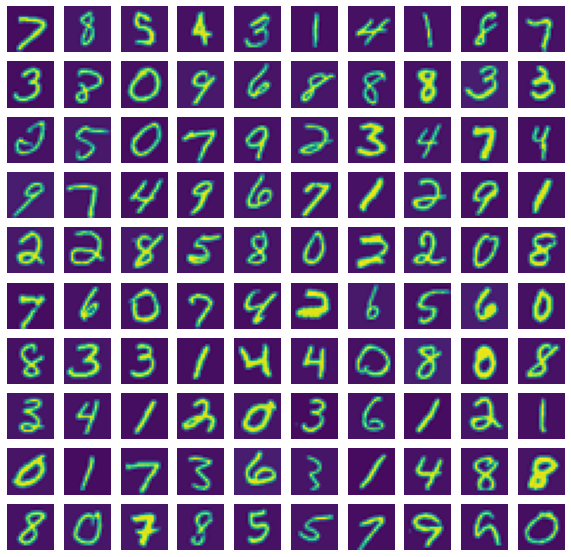

In [6]:
# Visualizar alguns dígitos aleatórios
visualizarDados(sel,10,10)

Queremos desenvolver uma rede neuronal de classificação multi-classe. No exercício anterior obtivemos os pesos pre-treinados e implementamos a Rede Neuronal com esses valores. Neste exercício vamos optimizar esses pesos usando uma combinação do gradiente descendente com a função de custo para cada camada da rede neuronal. Esta técnica tem o nome de retro-propagação.

# Exercício 1 - Desenvolvimento de Redes Neuronais - Função de Custo

<b>Vamos verificar a arquitectura da Rede Neuronal com uma camada oculta:

<img src="assets/NeuralNetwork.JPG">

In [7]:
# Carregar os pesos pre-treinados da rede neuronal.
ex4_pesos = io.loadmat('ex4weights.mat')

# Colocar os parâmetros numa dimensão
nn_params = np.append(ex4_pesos['Theta1'].ravel(),ex4_pesos['Theta2'].ravel())
nn_params = nn_params.reshape(len(nn_params),1)

Uma rede neuronal "feed-forward" calcula o custo sequencialmente para todas as camadas da rede neuronal.
<br>
A fórmula da função de custo é:

<img src="assets/CostFunctionNN.JPG">

E a versão regularizada:

<img src="assets/CostFunctionNNRegul.JPG">

<b> Um valor mais alto de lambda implica uma maior penalização nos parâmetros do modelo, reduzindo a probabilidade de overfitting.

Nas redes neuronais, uma forma de optimizar a função de custo é calcular o gradiente desde a camada de saída até à camada de entrada, sequencialmente. Com isto, o gradiente é calculado face ao mínimo da função de custo, sendo que este método é chamado de retro-propagação.

<img src="assets/BackpropagationNN.JPG">

In [8]:
# Definir a função sigmoide
def sigmoide(
    x: np.array
)-> np.array:
    '''
    Retorna o valor sigmóide para cada elemento do vector.
    
    Args:
        x(np.array): valor original de cada observação.
    Returns:
        (np.array): valores sigmoide do vector x.    
    '''
    return(1 / (1 + np.exp(-x)))

In [9]:
# Define Lambda - parâmetro de regularização
lambdas = 0

In [10]:
# Definir a função de custo e o gradiente da rede neuronal

def nnFuncaoDeCusto(
    nn_params: np.array, 
    tamanho_camada_entrada: int, 
    tamanho_camada_oculta: int, 
    num_labels: int,
    X: np.array, 
    y: np.array, 
    lambdas: float
):    
    '''
    Calcula a função de custo e os gradientes da Rede Neuronal
    usando a retro-propagação.
    A arquitectura desta rede consiste em:
        - 1 camada de entrada;
        - 1 camada oculta;
        - 1 camada de saída;
    Args:
        nn_params(np.array): Thetas iniciais
        tamanho_camada_entrada(int): Tamanho da camada de entrada
        tamanho_camada_oculta(int): Tamanho da camada oculta
        num_labels(int): Número de outputs
        X(np.array): Vector de valores originais das observações
        y(np.array): Vector com os valores target
        lambdas(float): Parâmetro de Regularização
    Returns:
        J(np.array): Valor da função de Custo 
        grad.flatten()(np.array): Vector achatado do gradiente
    '''
    
    # Redimensionar theta1 e theta2 para a sua dimensão original
    Theta1 = nn_params[0:(tamanho_camada_entrada+1) * tamanho_camada_oculta].reshape(tamanho_camada_oculta,tamanho_camada_entrada+1)
    
    Theta2 = nn_params[((tamanho_camada_entrada+1) * tamanho_camada_oculta):].reshape(num_labels,tamanho_camada_oculta+1)

    m = len(X)
    
    # Adicionar o bias term
    vector_uns = np.ones((len(X),1))
    X_extended = np.hstack((vector_uns,X))
    
    # Inicializar a função de custo
    J = 0  
    
    # Inicializar o gradiente de cada camada
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    y_real = np.zeros([num_labels,m])
    
    # Assignar o output    
    for i in range(1,num_labels+1):
        y_real[i-1,:] = (y==i).reshape(len(y),)
    
    # Calcular a função de custo para cada observação
    for t in range(0,m):
        
        # Calculos da camada oculta
        a1 = X_extended[t,:]
        z1 = np.dot(Theta1, a1.T)
        a2 = sigmoide(z1)
        # Adicionar o vector de uns
        a2 = np.append(1,a2)
        # Calculos da camada de output
        z2 = np.dot(Theta2, a2.T)
        hipotese = sigmoide(z2)
        # Actualizar a função de custo
        J = J+sum((-y_real[:,t]*np.log(hipotese) - (1-y_real[:,t])*np.log((1-hipotese))))
        # Deltas da retropropagação - valores de gradiente da camada oculta
        delta3 = hipotese - y_real[:,t]
        Theta2_grad = Theta2_grad + np.dot(delta3.reshape(len(delta3),1),a2.reshape(1,len(a2)))
        # Deltas da retropropagação - valores de gradiente da camada de entrada
        delta2 = np.dot(Theta2.T,delta3) * (a2*(1-a2))
        Theta1_grad = Theta1_grad + np.dot(delta2[1:].reshape(len(delta2[1:]),1),a1.reshape(1, len(a1)))
    
    # Ponderar erro por todas as observações
    J = J/m
    
    Theta1_grad = Theta1_grad / m
    Theta2_grad = Theta2_grad / m
    
    # Aplicar a regularização à função de custo
    J = J + ((lambdas / (2*m)) * ((Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum()))
    Theta1_grad = Theta1_grad + (lambdas / m) * np.hstack((np.zeros([Theta1.shape[0], 1]), Theta1[:,1:]))
    Theta2_grad = Theta2_grad + (lambdas / m) * np.hstack((np.zeros([Theta2.shape[0], 1]), Theta2[:,1:]))
    # Achatar os gradientes
    grad = np.append(Theta1_grad.ravel('F'),Theta2_grad.ravel('F'))
    grad = grad.reshape(len(grad),1)
    
    return J, grad.flatten()

In [11]:
# Definir a função de custo para Debug
def nnFuncaoDeCustoDebug(
    nn_params: np.array, 
    input_layer_size: int, 
    hidden_layer_size: int, 
    num_labels: int,
    X: np.array, 
    y: np.array, 
    lambdas: int
):    
    '''
    Calcula a função de custo e os gradientes da Rede Neuronal
    usando a retro-propagação - Versão alternativa.
    A arquitectura desta rede consiste em:
        - 1 camada de entrada;
        - 1 camada oculta;
        - 1 camada de saída;
    Args:
        nn_params(np.array): Thetas iniciais
        tamanho_camada_entrada(int): Tamanho da camada de entrada
        tamanho_camada_oculta(int): Tamanho da camada oculta
        num_labels(int): Número de outputs
        X(np.array): Vector de valores originais das observações
        y(np.array): Vector com os valores target
        lambdas(float): Parâmetro de Regularização
    Returns:
        J(np.array): Valor da função de Custo 
        grad.flatten()(np.array): Vector achatado do gradiente
    '''
    
    # Redimensionar Theta1 e Theta2 para a sua dimensão original
    Theta1 = nn_params[0:(input_layer_size+1) * hidden_layer_size].reshape(hidden_layer_size,input_layer_size+1, order='F')
    Theta2 = nn_params[((input_layer_size+1) * hidden_layer_size):].reshape(num_labels,hidden_layer_size+1, order='F')
    
    m = len(X)
    # Adicionar o vector de uns 
    vector_uns = np.ones((len(X),1))
    X_extended = np.hstack((vector_uns,X))
    
    # Inicializar a função de custo
    J = 0  
    # Inicializar os gradientes
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    y_real = np.zeros([num_labels,m])
    # Assinar os outputs
    for i in range(1,num_labels+1):
        y_real[i-1,:] = (y==i).reshape(len(y),)
    # Actualizar a função de custo e o gradiente iterativamente
    for t in range(0,m):  
        # Funções da camada oculta
        a1 = X_extended[t,:]
        z1 = np.dot(Theta1, a1.T)
        a2 = sigmoide(z1)
        # Adicionar o intercept à camada oculta
        a2 = np.append(1,a2)
        # Calculos da camada de output
        z2 = np.dot(Theta2, a2.T)
        hipotese = sigmoide(z2)
        # Update cost function
        J = J+sum((-y_real[:,t]*np.log(hipotese) - (1-y_real[:,t])*np.log((1-hipotese))))
        # Retropropagação da camada oculta
        delta3 = hipotese - y_real[:,t]
        Theta2_grad = Theta2_grad + np.dot(delta3.reshape(len(delta3),1),a2.reshape(1,len(a2)))
        # Retropropagação da camada de entrada
        delta2 = np.dot(Theta2.T,delta3) * (a2*(1-a2))
        Theta1_grad = Theta1_grad + np.dot(delta2[1:].reshape(len(delta2[1:]),1),a1.reshape(1, len(a1)))
    # Ponderar o erro por todas as observações 
    J = J/m    
    Theta1_grad = Theta1_grad / m
    Theta2_grad = Theta2_grad / m
    # Aplicar a regularização à função de custo e ao gradiente
    J = J + ((lambdas / (2*m)) * ((Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum()))
    Theta1_grad = Theta1_grad + (lambdas / m) * np.hstack((np.zeros([Theta1.shape[0], 1]), Theta1[:,1:]))
    Theta2_grad = Theta2_grad + (lambdas / m) * np.hstack((np.zeros([Theta2.shape[0], 1]), Theta2[:,1:]))
    # Redimensionar o gradiente
    grad = np.append(Theta1_grad.ravel('F'),Theta2_grad.ravel('F'))
    grad = grad.reshape(len(grad),1)
    
    return J, grad.flatten()

In [12]:
# Calcular a função de custo e o gradiente
J, grad = nnFuncaoDeCusto(nn_params, nos_camada_entrada, 
                  nos_camada_oculta, num_targets,
                  X, y, lambdas)

In [13]:
print('A função de custo com um lambda = 0 é {0:.3g}'.format(J))

A função de custo com um lambda = 0 é 0.288


In [14]:
# Testar com um valor de regularização maior
J_lambda_1, lambda_grad_1 = nnFuncaoDeCusto(nn_params, nos_camada_entrada, 
                  nos_camada_oculta, num_targets,
                  X, y, 1)

In [15]:
print('A função de custo para o lambda = 1 é {0:.3g}'.format(J_lambda_1))

A função de custo para o lambda = 1 é 0.384


# Exercício 2 - Retropropagação

Vamos implementar o gradiente sigmoide. A formula é:

<img src="assets/SigmoidGradient.JPG">

In [16]:
def gradienteSigmoide(
    z: np.array
): 
    '''
    Calcular a activação sigmoide para a retropropagação.
    Args:
        z(np.array): Valores originais de z
    Returns:
        (np.array): Valor gradiente da sigmoide de z
    '''
    return sigmoide(z)*(1-sigmoide(z))

In [17]:
g = gradienteSigmoide(np.array([-1, -0.5, 0, 0.5, 1]))

In [18]:
print('O gradiente sigmóide em [-1, -0.5, 0, 0.5, 1]: {}'.format(np.round(g,3)))

O gradiente sigmóide em [-1, -0.5, 0, 0.5, 1]: [0.197 0.235 0.25  0.235 0.197]


**Primeiro vamos utilizar um método de teste de implementação da retropropação:**

In [19]:
# Inicializar os parâmetros da rede neuronal aleatoriamente
def InicializarPesosAleatorios(
    L_in: int, 
    L_out: int
) -> np.array:
    '''
    Inicializa os parâmetros da rede neuronal aleatoriamente.
    Args:
        L_in(int): Numero de nós da camada de entrada aleatoriamente inicializada.
        L_out(int): Numero de nós da camada de saída aleatoriamente inicializada.
    Returns:
        W(np.array): Inicialização aleatória dos pesos da rede neuronal
    '''
    epsilon_init = 0.12
    W = np.random.rand(L_in, 1+L_out) * 2 * epsilon_init - epsilon_init
    
    return W

In [20]:
# Generate initial weights for Theta 1 and Theta 2
inicial_Theta1 = InicializarPesosAleatorios(nos_camada_entrada, nos_camada_oculta)
inicial_Theta2 = InicializarPesosAleatorios(nos_camada_oculta, num_targets)

In [21]:
# Redimensionar os parametros aleatórios da rede neuronal numa única coluna
inicial_nn_params =np.append(inicial_Theta1.ravel(),inicial_Theta2.ravel())
inicial_nn_params = inicial_nn_params.reshape(len(inicial_nn_params),1)

Depois de inicializar os pesos aleatoriamente, vamos usar uma função de comparação de gradiente para validar a implementação.

In [22]:
def debugPesosInicializados(
    fan_out: int, 
    fan_in: int
) -> np.array:
    '''
    Inicializar os pesos.
    Esta função será usado para fazer despistar eventuais erros 
    à rede neuronal.
    
    Args:
        fan_out(int): Tamanho da camada de saída.
        fan_in(int): Tamanho da camada de entrada.
    Returns:
        W(np.array): Pesos da rede neuronal inicializada.  
    '''
    
    W = np.zeros([fan_out, 1 + fan_in])
    # Usamos a order ='F' para manter o mesmo formato que o octave
    W = np.sin(np.arange(1,W.size+1)).reshape(W.shape, order='F')/10
    return W

def calcularGradienteNumerico(
    J: callable, 
    theta: np.array, 
    nos_camada_entrada: int, 
    nos_camada_oculta: int, 
    num_outputs: int,
    X: np.array, 
    y: np.array, 
    lambdas: float
)-> np.array:
    
    '''
    Calcular o gradiente numérico usando "diferenças finitas", dando-nos uma 
    estimação numérica do gradiente.
    
    Args:
        J(callable): Função que devolve o custo e o gradiente-
        theta(np.array): Vector de thetas.
        nos_camada_entrada(int): Tamanho da camada de entrada.
        nos_camada_oculta(int): Tamanho da camada oculta.
        num_outputs(int): Número de labels.
        X(np.array): Valores das observações originais.
        y(np.array): Valores target.
        lambdas(float): Parâmetros de regularização.
    '''
    theta = theta.reshape(theta.shape[0],1, order='F')
    
    numgrad = np.zeros(theta.shape[0])
    perturb = np.zeros(theta.shape[0])
    
    e = 1e-4
    
    for i in range(0,len(theta)):
        perturb[i] = e
        loss1 = J((theta - perturb.reshape(len(theta),1)), nos_camada_entrada, nos_camada_oculta, num_outputs, X, y, lambdas)
        loss2 = J((theta + perturb.reshape(len(theta),1)), nos_camada_entrada, nos_camada_oculta, num_outputs, X, y, lambdas)
        #Compute Numerical Gradient
        numgrad[i] = (loss2[0]-loss1[0])/ (2*e)
        perturb[i] = 0
    
    return numgrad.flatten()

def verificarGradienteRedeNeuronal(
    lambdas: float
) -> None:
    '''
    Cria uma rede neuronal simples e verifica 
    o gradiente calculado pelos dois métodos.
    O print resultante deve ser aproximadamente zero.
    
    Args:
        lambdas(float): Parâmetro de regularização
    Returns:
        None
    '''
    nos_camada_entrada = 3
    nos_camada_oculta = 5
    numero_outputs = 3
    m = 5
    
    Theta1 = debugPesosInicializados(nos_camada_oculta, nos_camada_entrada);
    Theta2 = debugPesosInicializados(numero_outputs, nos_camada_oculta);
    
    # Gerar dados falsos para X e Y
    
    X  = debugPesosInicializados(m, nos_camada_entrada - 1)
    y  = 1+np.mod(np.arange(0,m+1),3)[1:]

    # Achatar o vector de parametros
    nn_params = np.append(Theta1.ravel(),Theta2.ravel())
    
    nn_params_orig = np.append(Theta1.ravel('F'),Theta2.ravel('F'))
    
    nn_params = nn_params.reshape(len(nn_params),1)
    
    cost,grad = nnFuncaoDeCusto(nn_params, nos_camada_entrada, 
                  nos_camada_oculta, numero_outputs,
                  X, y, lambdas)
    numgrad = calcularGradienteNumerico(nnFuncaoDeCustoDebug, nn_params_orig, nos_camada_entrada, 
                  nos_camada_oculta, numero_outputs,
                  X, y, lambdas)
    
    diff = norm(numgrad-grad)/norm(numgrad+grad)
    
    print("""Se a implementação da retropropagação estiver correcta então a diferença relativa entre os gradientes deverá ser infinitamente pequena (aproximadamente zero). The diff is {}""".format(diff))

In [23]:
# Verificar a implementação da retropropagação
verificarGradienteRedeNeuronal(0)

Se a implementação da retropropagação estiver correcta então a diferença relativa entre os gradientes deverá ser infinitamente pequena (aproximadamente zero). The diff is 2.4953294856388945e-11


Vamos utilizar a função optimize do scipy para treinar a rede neuronal - usamos 10 iterações de treino.

In [24]:
lambdas = 1

res = optimize.minimize(nnFuncaoDeCustoDebug, nn_params, 
               method='BFGS', args=(nos_camada_entrada,
                                        nos_camada_oculta,
                                        num_targets, X, y, lambdas), jac=True, options={'maxiter': 10,  "disp":True})

         Current function value: 1.461544
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


In [25]:
nn_params_optimizacao = res.x
custo = res.fun

# Obtain the optimized thetas
Theta1 = np.reshape(nn_params[:nos_camada_oculta * (nos_camada_entrada + 1)],
                    (nos_camada_oculta, (nos_camada_entrada + 1)))

Theta2 = np.reshape(nn_params[(nos_camada_oculta * (nos_camada_entrada + 1)):],
                    (num_targets, (nos_camada_oculta + 1)))

In [26]:
# A função de custo depois de 10 iterações
custo

1.461544070403664

Uma das formas de visualizar os efeitos de uma rede neuronal é verificar os pesos da camada oculta.<br>
Visualizando os pesos para algumas observações conseguimos perceber as features que a rede neuronal está a tentar aprender ao minimizar a função de custo.

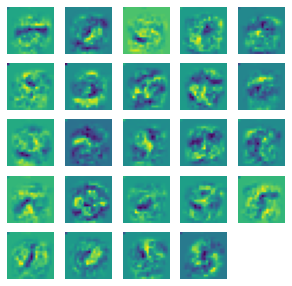

In [27]:
# Visualizar a camada oculta 
visualizarDados(Theta1[:,:400],5,5)

In [28]:
# Definir a função que permite prever o dígito com base na rede neuronal
def prever(
    Theta1: np.array, 
    Theta2: np.array, 
    X: np.array
)-> np.array:
    '''
    Usa a probabilidade máxima da Rede Neuronal como 
    valor previsto para cada element do vector X.
    Retorna o vector de previsões.
    Args:
        Theta1(np.array): Pesos para a camada oculta.
        Theta2(np.array): Pesos para a camada de saída.
        X(np.array): Valores das features para cada uma das observações. 
    Returns: 
        (np.array): vector de previsões
    '''
    m = X.shape[0]

    # Adicionar intercept
    vector_uns = np.ones((len(X),1))
    X_extended = np.hstack((vector_uns,X))
    
    staging_1 = sigmoide(np.dot(X_extended,Theta1.T))
    
    # Adicionar intercept ao vector staging_1
    staging_1 = np.hstack((vector_uns,staging_1))
    
    staging_2 = sigmoide(np.dot(staging_1, Theta2.T))
    
    # Vamos usar a função idmax do pandas para obter a maior probabilidade para cada dígito.
    prediction = pd.DataFrame(staging_2).idxmax(axis=1)+1
    
    return np.array(prediction)

In [29]:
pred = prever(Theta1,Theta2,X)

In [30]:
pred

array([10, 10, 10, ...,  9,  9,  9])

**Podemos agora verificar a taxa de acerto da nossa rede neuronal:**

In [31]:
# Verificar taxa de acerto da rede neuronal
print("Taxa de acerto da rede neuronal é {:.2%} ".format(sum(np.array([1 if val == True else 0 for val in pred.reshape(len(y),1)==y]))/len(y)))

Taxa de acerto da rede neuronal é 97.52% 


As redes neuronais são algoritmos bastante poderosos - muitos projectos de machine learning usam-nas para obter previsões com maior qualidade. A quantidade quase infinita de combinação de  hiperparâmetros (adicionar camadas ocultas, mudar o número de nós por camada, parâmetros de regularização, etc.) fazem-nas bastante flexíveis a várias arquitecturas, permitindo com que aprendam estruturas e funções complexas. 